In [3]:
from qiskit import transpile ,QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Operator, DensityMatrix, partial_trace, Pauli
from qiskit.visualization import plot_state_qsphere
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import RYGate, RZGate, CXGate, CRYGate, n_local
import numpy as np, array
from IPython.display import display, Latex
# SciPy minimizer routine
from scipy.optimize import minimize
#from skquant.interop.scipy import imfil
import time
import string
import pickle
from pathlib import Path
from qadc.circuits import *
from qadc.utils import *
from qadc.circuits import BaseAmplitudeDampingCircuit as BADC
from qadc.simulators import *
from qiskit.quantum_info import Statevector
from qiskit.circuit import ClassicalRegister
project_root = Path().resolve().parents[1]/"result"/"risultati_ad_entanglement"
print(project_root)
print(project_root.exists())

C:\Users\rem.gabryldellarosa\OneDrive - Universita degli Studi Roma Tre\Desktop\Tesi\quantum-amplitude-damping-channel\result\risultati_ad_entanglement
True


In [3]:
def crea_cartelle_risultati(base_dir="risultati_ottimizzatore"):
    import os
    """
    Crea la struttura di cartelle per salvare i risultati dell'ottimizzazione.
    
    Parametri:
        base_dir (str): cartella principale in cui salvare i risultati
        lista_eta (list): lista dei valori η per cui creare le sottocartelle
    """
    path_root = os.path.join(base_dir, "risultati")
    os.makedirs(path_root, exist_ok=True)
    path_andamento = os.path.join(path_root, "risultati_ottimizzazione")
    path_bloch = os.path.join(path_root, "visualizzazione_risultati")

    # Crea le due cartelle principali
    os.makedirs(path_andamento, exist_ok=True)
    os.makedirs(path_bloch, exist_ok=True)
    return [path_root,path_andamento,path_bloch]

    

def salva_plot_png(fig, base_name = "grafico",base_dir="risultati_ottimizzatore", subfolder="risultati_ottimizzazione", _create = False, name_create =""):
    import os
    """
    Salva un plot matplotlib in una cartella strutturata in base al valore del damping (noise).

    Parameters:
    - fig: oggetto matplotlib.figure.Figure
    - noise_value: valore di eta o n usato per la simulazione
    - base_dir: cartella radice per i risultati
    - subfolder: sotto-cartella per tipo di contenuto
    """
    dir_path = os.path.join(base_dir,subfolder)
    if _create == True:
        dir_path = os.path.join(dir_path, name_create)
        os.makedirs(dir_path, exist_ok=True)

    filename = os.path.join(dir_path, base_name+".png")
    fig.savefig(filename, dpi=300, bbox_inches='tight')

def salva_plot_plotly(fig, base_name = "grafico_3D_eta_",base_dir="risultati_ottimizzatore", subfolder="visualizzazione_risultati",_create = False, name_create = None):
    import os
    """
    Salva un plot Plotly (interattivo) come HTML in una struttura di cartelle.

    Parameters:
    - fig: oggetto plotly.graph_objects.Figure
    - noise_value: valore di eta o n usato per la simulazione
    - base_dir: cartella radice per i risultati
    - subfolder: sotto-cartella per tipo di contenuto
    """
    dir_path = os.path.join(base_dir,subfolder)
    if _create == True:
        dir_path = os.path.join(dir_path, f""+name_create)
        os.makedirs(dir_path, exist_ok=True)

    filename = os.path.join(dir_path, base_name)
    fig.write_html(filename+".html")
   # fig.write_image(filename+".png",width=1200, height=900, scale=1)


# Fase 1 Modellare il problema

## Modello Ancilla & Encoding

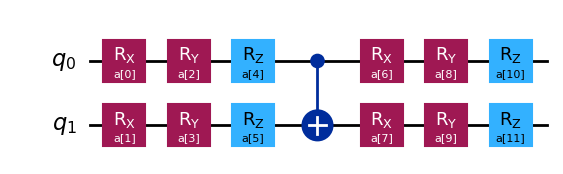

In [4]:

# 2 qubit, rotazioni RX/RY/RZ, entanglement CNOT
En = n_local(num_qubits=2,
              rotation_blocks=['rx', 'ry', 'rz'],
              entanglement_blocks='cx',
              reps=1,        # quante volte ripetere lo schema
              parameter_prefix="a",
              insert_barriers=False)

# Possiamo per il momento omettere l'ottimizzazione di stati misti, per questo scelgo invece di 6 qubit, 4 qubit di cui 2 
# di sistema e 2 di ambiente
# qc.compose(AncillaInitializationCircuit(Parameter("A")),[0,2], inplace=True )
# qc.compose(AncillaInitializationCircuit(Parameter("B")),[3,5], inplace=True )

display(En.draw("mpl"))
#display(qc.draw("mpl"))

# from qiskit.circuit.library import efficient_su2
# esu = efficient_su2(2, su2_gates=["rx","ry","rz"], entanglement="full", reps=1)
# display(esu.draw("mpl"))

## Modello Decoding 

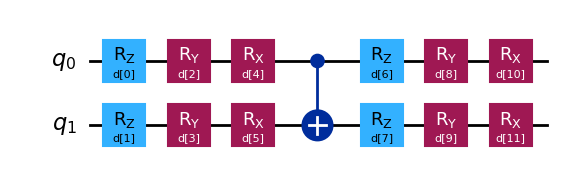

In [5]:
De = n_local(num_qubits=2,
              rotation_blocks=['rz', 'ry', 'rx'],
              entanglement_blocks='cx',
              reps=1,        # quante volte ripetere lo schema
              parameter_prefix="d",
              insert_barriers=False)
De.draw("mpl")

## Modello completo del canale

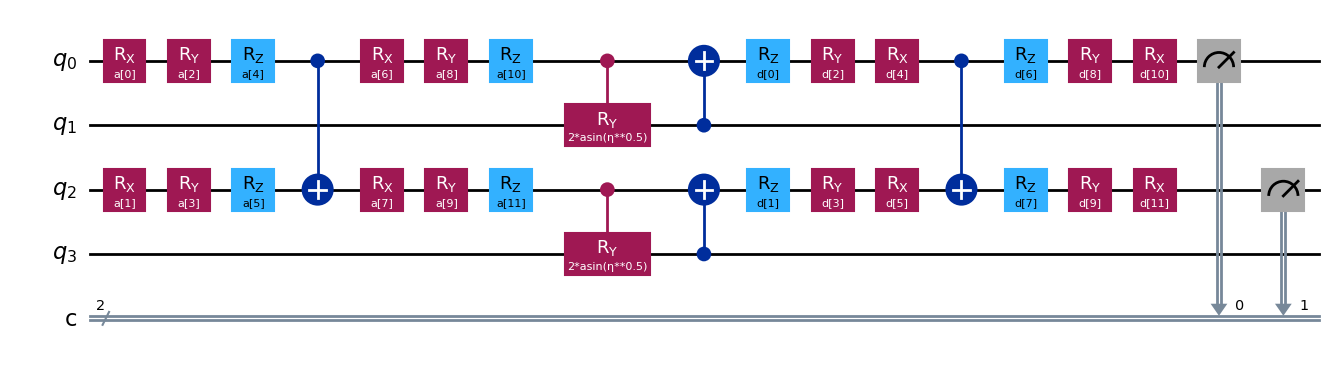

In [ ]:
noise = Parameter("η")
Ad = AmplitudeDampingConvenzioneQiskit(BaseAmplitudeDampingCircuit.noise_to_theta(noise))
qc = QuantumCircuit(4,2)
qc.compose(En, [0,2], inplace=True) # con ancilla avrò [0,3]
qc.compose(Ad,[0,1], inplace = True) # con ancilla rimane cosi
qc.compose(Ad,[2,3], inplace = True) # con ancilla avrò 
qc.compose(De, [0,2], inplace = True)
qc.measure(0,0)
qc.measure(2,1)

param_circuit = qc.parameters.data
param_circuit.remove(Ad.parameters.data[0])
qc_exp = qc.copy()
new_param_circuit = ParameterVector("R", len(param_circuit))
qc.assign_parameters({ param_circuit[i] : new_param_circuit[i] for i in range(qc.num_parameters-1)}, inplace=True)
qc_exp.draw("mpl")

## Canale da utilizzare in ottimizzazione 

In [7]:
def factory_channels(num_channels, qc_example, changes_param, labels=None):
    """
    Crea un circuito composto da più canali (repliche del circuito di esempio),
    ciascuno con i propri parametri.

    Args:
        num_channels (int): numero di canali da replicare
        qc_example (QuantumCircuit): circuito base da replicare
        changes_param (list): parametri del circuito da sostituire in ogni copia
        labels (list, opzionale): etichette da assegnare ai parametri
                                  (una per ogni canale). Se fornita e con lunghezza diversa da
                                  num_channels, viene sollevata un'eccezione.

    Returns:
        QuantumCircuit: circuito finale con tutti i canali replicati
        list[tuple]: lista ordinata dei parametri per ciascun canale
    """
    if not changes_param or len(changes_param) == 0:
        raise ValueError("È necessario specificare i parametri da sostituire (changes_param).")

    if labels is not None and len(labels) != num_channels:
        raise ValueError("Il numero di label fornito non corrisponde al numero di canali.")

    # uso lettere maiuscole di default se non vengono fornite labels
    letter_uppercase = list(string.ascii_uppercase)
    if labels is None:
        labels = letter_uppercase[:num_channels]

    num_meas_of_single_channels = qc_example.num_clbits
    num_qubit_of_single_channels = qc_example.num_qubits

    # circuito finale con num_channels * num_qubits
    qc_final = QuantumCircuit(num_qubit_of_single_channels * num_channels)

    # # lista ordinata dei parametri
    # params_ordered = []

    for i in range(num_channels):
        label = labels[i]

        # aggiungo registri classici per le misure
        qc_final.add_register(ClassicalRegister(num_meas_of_single_channels, f"c{label}"))

        # creo nuovi parametri per questo canale
        param_vec = ParameterVector(label, len(changes_param))

        # sostituisco i parametri nel circuito di esempio
        qc_temp = qc_example.assign_parameters(
            {changes_param[j]: param_vec[j] for j in range(len(changes_param))}
        )

        # compongo il circuito nel circuito finale
        qc_final.compose(
            qc_temp,
            [j + i * num_qubit_of_single_channels for j in range(num_qubit_of_single_channels)],
            [j + i * num_meas_of_single_channels for j in range(num_meas_of_single_channels)],
            inplace=True,
        )

        # # aggiorno lista parametri ordinati
        # params_ordered.extend([(label, p) for p in param_vec])

    return qc_final, label

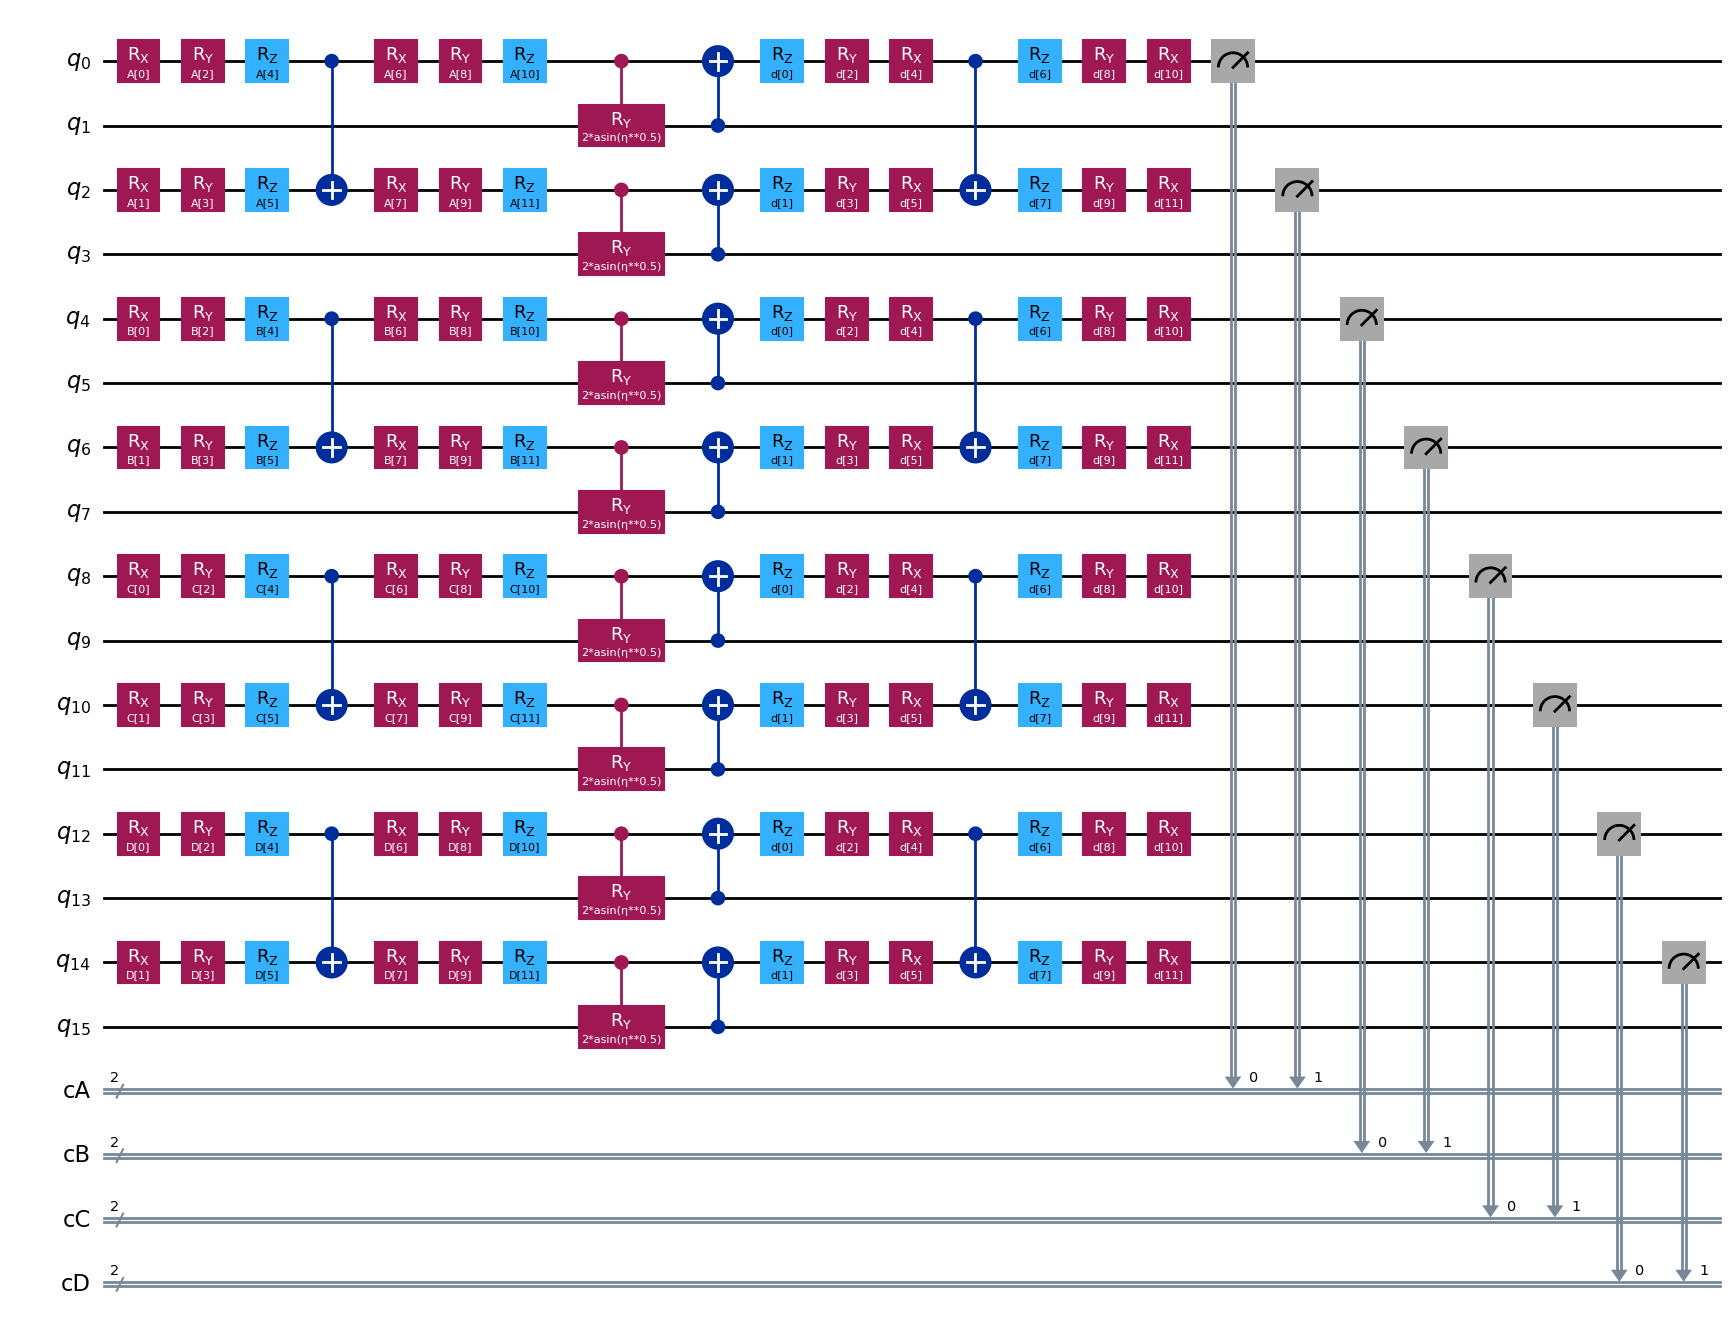

{'A': ParameterVector(name='A', length=12), 'B': ParameterVector(name='B', length=12), 'C': ParameterVector(name='C', length=12), 'D': ParameterVector(name='D', length=12)}
['A', 'B', 'C', 'D']


In [8]:
num_channels = 4
changes_param = En.parameters
qc_be_opt = QuantumCircuit(qc.num_qubits * num_channels)
letter_uppercase = list(string.ascii_uppercase)
num_meas_of_single_channels = qc.num_clbits
num_qubit_of_single_channels = qc.num_qubits
label_params = {}
keys_sorted = []
for i in range(num_channels):
    let = letter_uppercase[i]
    qc_be_opt.add_register(ClassicalRegister(num_meas_of_single_channels,"c"+let))
    #qc_be_opt.add_register(ClassicalRegister(2,"cB"))
    param = ParameterVector(let, len(changes_param))
    #paramsB = ParameterVector("B", len(param_circuit))
    qc_t = qc_exp.assign_parameters({changes_param[j]:param[j] for j in range(len(changes_param))})
    #qc_b = qc.assign_parameters({new_param_circuit[i]:paramsB[i] for i in range(len(param_circuit))})
    qc_be_opt.compose(qc_t,
                    [j+i*qc_t.num_qubits for j in range(qc_t.num_qubits)],
                    [j+i*num_meas_of_single_channels for j in range(num_meas_of_single_channels)],
                    inplace=True)
    label_params.update({let : param})
    keys_sorted.append(let)
#qc_be_opt.compose(qc_b,[qc_a.num_qubits+i for i in range(qc_b.num_qubits)], [2,3],inplace=True)
# qc_be_opt.assign_parameters({noise:0},inplace=True)
# qc_be_opt.assign_parameters(range(qc_be_opt.num_parameters),inplace=True)
display(qc_be_opt.draw("mpl"))
print(label_params)
print(keys_sorted)
# # qc
# print(qc_be_opt.parameters)
# result = IdealSimulator().run([(qc_be_opt,
#                                 #np.random.uniform(0, 2 * np.pi, size=qc_be_opt.num_parameters)
#                                 [], 
#                                 1000)])
# counts = [ result[0].data[c].get_counts() for c in result[0].data]
# print(counts)

# simulazione e ottimizzazione

## Funzioni ausiliari

In [9]:
def cost_function(counts):
    """
    Calcola la stima della probabilità di errore media degli esiti di misura utilizzando il metodo della massima verosimiglianza.

    Parametri:
    -----------
    counts : list of dict
        Lista di dizionari. Ogni dizionario rappresenta i conteggi di misura
        per una diversa classe (o esperimento), con chiavi '0' e '1' che indicano
        il numero di volte in cui ciascun risultato è stato ottenuto.

        Esempio:
            counts = [
                {'0': 900, '1': 100},   # Esperimento A
                {'0': 200, '1': 800}    # Esperimento B
            ]

    Ritorna:
    --------
    float
        Valore della funzione costo
    """
    return Utils.cost_function(counts)

def merge_dict(dicts):
    """
    Unisce una lista di dizionari in un singolo dizionario, in cui i valori associati
    a ciascuna chiave sono raccolti in una lista ordinata.

    Parametri:
    -----------
    dicts : list of dict
        Una lista di dizionari, tutti con lo stesso insieme di chiavi (o parzialmente sovrapposti).
        Esempio:
            [{'a': 1, 'b': 2}, {'a': 3, 'b': 4}, {'a': 5, 'b': 6}]

    Ritorna:
    --------
    dict
        Un dizionario in cui ogni chiave è associata a una lista di valori
        raccolti nell'ordine dei dizionari originali.
        Esempio output:
            {'a': [1, 3, 5], 'b': [2, 4, 6]}
    """
    return Utils.merge_dict(dicts)

## Funzioni costo wrapper

In [10]:
def cost_wrapper_scipy_mode_1(theta_vector,qc,shots,mode : AbstractSimulator,cost_history):
    # mettere la gestione dei parametri in un metodo del circuito stesso
    if not(len(theta_vector) == 2*qc.num_parameters): 
        raise ValueError(f"Attesi {2*qc.num_parameters} parametri")
    params = qc.parameters
    result = mode.run([(qc,{ params[i] :theta_vector[i] for i in range(qc.num_parameters)}, shots),(qc,{ params[i] :theta_vector[i+qc.num_parameters] for i in range(qc.num_parameters)}, shots)])
    #counts = result[0].data.c.get_counts()
    # Estrae i conteggi delle misure per ogni esperimento, che dovrebbero essere 2.
    # Passa questi conteggi alla funzione costo, che valuta quanto sono statisticamente separabili.
    #cost = cost_function([marginal_counts(counts,[i]) for i in range(len(next(iter(counts))))])
    cost = cost_function([i.data[c].get_counts() for i in result for c in i.data])
    cost_history.append([cost] + list(theta_vector))
    #print([cost] + list(theta_vector))
    return cost

In [11]:
def cost_wrapper_scipy_mode_2(theta_vector,qc,shots,mode : AbstractSimulator,cost_history):
    # mettere la gestione dei parametri in un metodo del circuito stesso
    if not(len(theta_vector) == qc.num_parameters): 
        raise ValueError(f"Attesi {qc.num_parameters} parametri")
    params = qc.parameters
    result = mode.run([(qc,theta_vector,shots)])
    #counts = result[0].data.c.get_counts()
    # Estrae i conteggi delle misure per ogni esperimento, che dovrebbero essere 2.
    # Passa questi conteggi alla funzione costo, che valuta quanto sono statisticamente separabili.
    #cost = cost_function([marginal_counts(counts,[i]) for i in range(len(next(iter(counts))))])
    cost = cost_function([i.data[c].get_counts() for i in result for c in i.data])
    cost_history.append([cost] + list(theta_vector))
    #print([cost] + list(theta_vector))
    return cost

## Ottimizzazione con COBYQA

In [12]:
save = True
radice, risultati, visualizzazione = crea_cartelle_risultati(project_root)
#noises = np.linspace(0.0, 0.9, 5)
x0 = np.random.uniform(0, 2 * np.pi, size=(qc_be_opt.num_parameters-1))
noises=[0]
# r , _, _ = all_simulation[2]
# x0 = r.x
if save : 
    salva_plot_png(qc_be_opt.draw("mpl"), base_name = "circuito_ottimizzazione", base_dir=radice,subfolder=risultati, _create=True)
print(x0)
met0 = "COBYQA"
met1 = "COBYQA"
mode = IdealSimulator()

[1.48251331 4.00328874 6.0319463  0.28141155 0.0930448  0.83818411
 4.73408018 5.43205051 6.27782783 2.97031435 4.57550713 4.94944492
 6.01029476 6.04425423 0.65235798 2.26714245 3.12420037 4.65201967
 5.11331635 4.13612365 1.53955167 2.81024947 1.66469102 1.56566323
 5.05866225 2.32008551 6.13892632 3.02861517 3.88770401 5.39503328
 4.13718229 4.37199291 4.74130593 5.7733138  2.97168896 4.47657064
 0.2828785  3.44376377 1.97301722 5.84816932 3.39615368 3.88807051
 1.10251922 1.29125411 2.16273381 2.1385973  5.60030701 4.65699224
 0.81249471 0.64351397 2.65327693 5.98769957 4.65553006 0.52574062
 4.21966989 2.66237313 0.29901841 1.31643704 2.83550388 2.77949992]


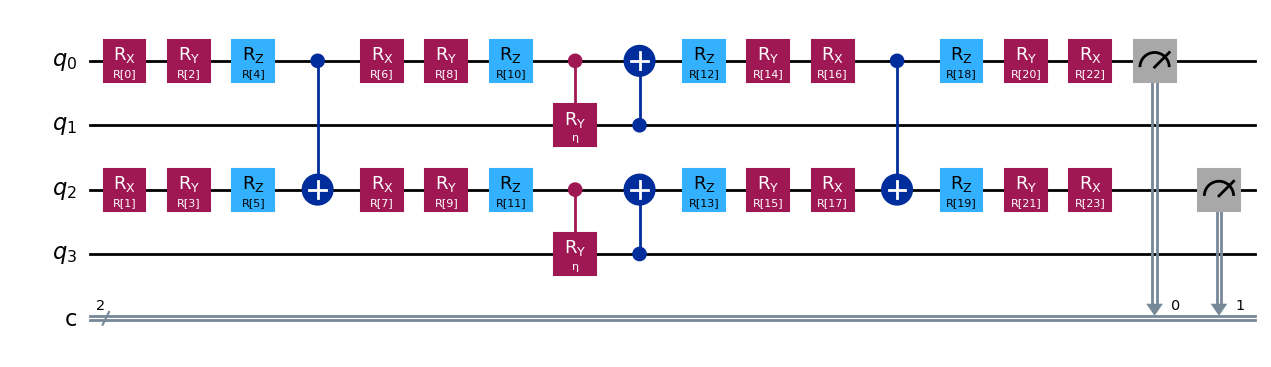

Starting the optimization procedure.
Initial trust-region radius: 1.0.
Final trust-region radius: 1e-05.
Maximum number of function evaluations: 24000.
Maximum number of iterations: 1000.

cost_wrapper_scipy_mode_1([ 1.242e+00  6.283e+00 ...  3.000e+00  2.042e+00]) = 0.33305000000000007
cost_wrapper_scipy_mode_1([ 2.242e+00  6.283e+00 ...  3.000e+00  2.042e+00]) = 0.36515
cost_wrapper_scipy_mode_1([ 1.242e+00  5.283e+00 ...  3.000e+00  2.042e+00]) = 0.32443
cost_wrapper_scipy_mode_1([ 1.242e+00  6.283e+00 ...  3.000e+00  2.042e+00]) = 0.3591
cost_wrapper_scipy_mode_1([ 1.242e+00  6.283e+00 ...  3.000e+00  2.042e+00]) = 0.39435999999999993
cost_wrapper_scipy_mode_1([ 1.242e+00  6.283e+00 ...  3.000e+00  2.042e+00]) = 0.27862999999999993
cost_wrapper_scipy_mode_1([ 1.242e+00  6.283e+00 ...  3.000e+00  2.042e+00]) = 0.35545000000000004
cost_wrapper_scipy_mode_1([ 1.242e+00  6.283e+00 ...  3.000e+00  2.042e+00]) = 0.33846
cost_wrapper_scipy_mode_1([ 1.242e+00  6.283e+00 ...  3.000e+00  2.0

KeyboardInterrupt: 

In [14]:
if save :
    salva_plot_png(qc.draw("mpl"), base_name = "circuito_ottimizzazione", base_dir=radice,subfolder=risultati, _create=True)
display(qc.draw("mpl"))
all_simulation = []
for n in noises:
    start_time = time.time()
    cost_history = []
    qc_set_noise = qc.assign_parameters({noise : n})
    cost_wrapper_scipy_mode_1(x0,qc_set_noise, 10000, mode, cost_history)
    result = minimize(
        cost_wrapper_scipy_mode_1,
        x0,
        args=(qc_set_noise, 50000, mode, cost_history),
        method=met0,
        bounds=np.array(list([(-0*np.pi, 2*np.pi)]*2*(qc.num_parameters-1))),
        tol = 0.00001,
        options={
                "maxiter": 1000, 
                "disp": True,
                }
    )
    # result = minimize(
    #     cost_wrapper_scipy,
    #     result.x,
    #     args=(qc_set_noise, 500000, mode, cost_history),
    #     method=met1,
    #     bounds=np.array(list([(-0*np.pi, 2*np.pi)]*2*(qc.num_parameters-1))),
    #     tol = 0.000001,
    #     options={
    #             "maxiter": 200, 
    #             "disp": True,
    #             }
    # )
    all_simulation.append((result,cost_history,n))
    end_time = time.time()
    execution_time = end_time - start_time
    print(result)
    print(f"""print optimal parameters: {result.x}""")
    print(f"""Number of iterations: {result.nfev}""")
    print(f"""Time (s): {execution_time}""")
    print(f"""result: {result.fun}""")

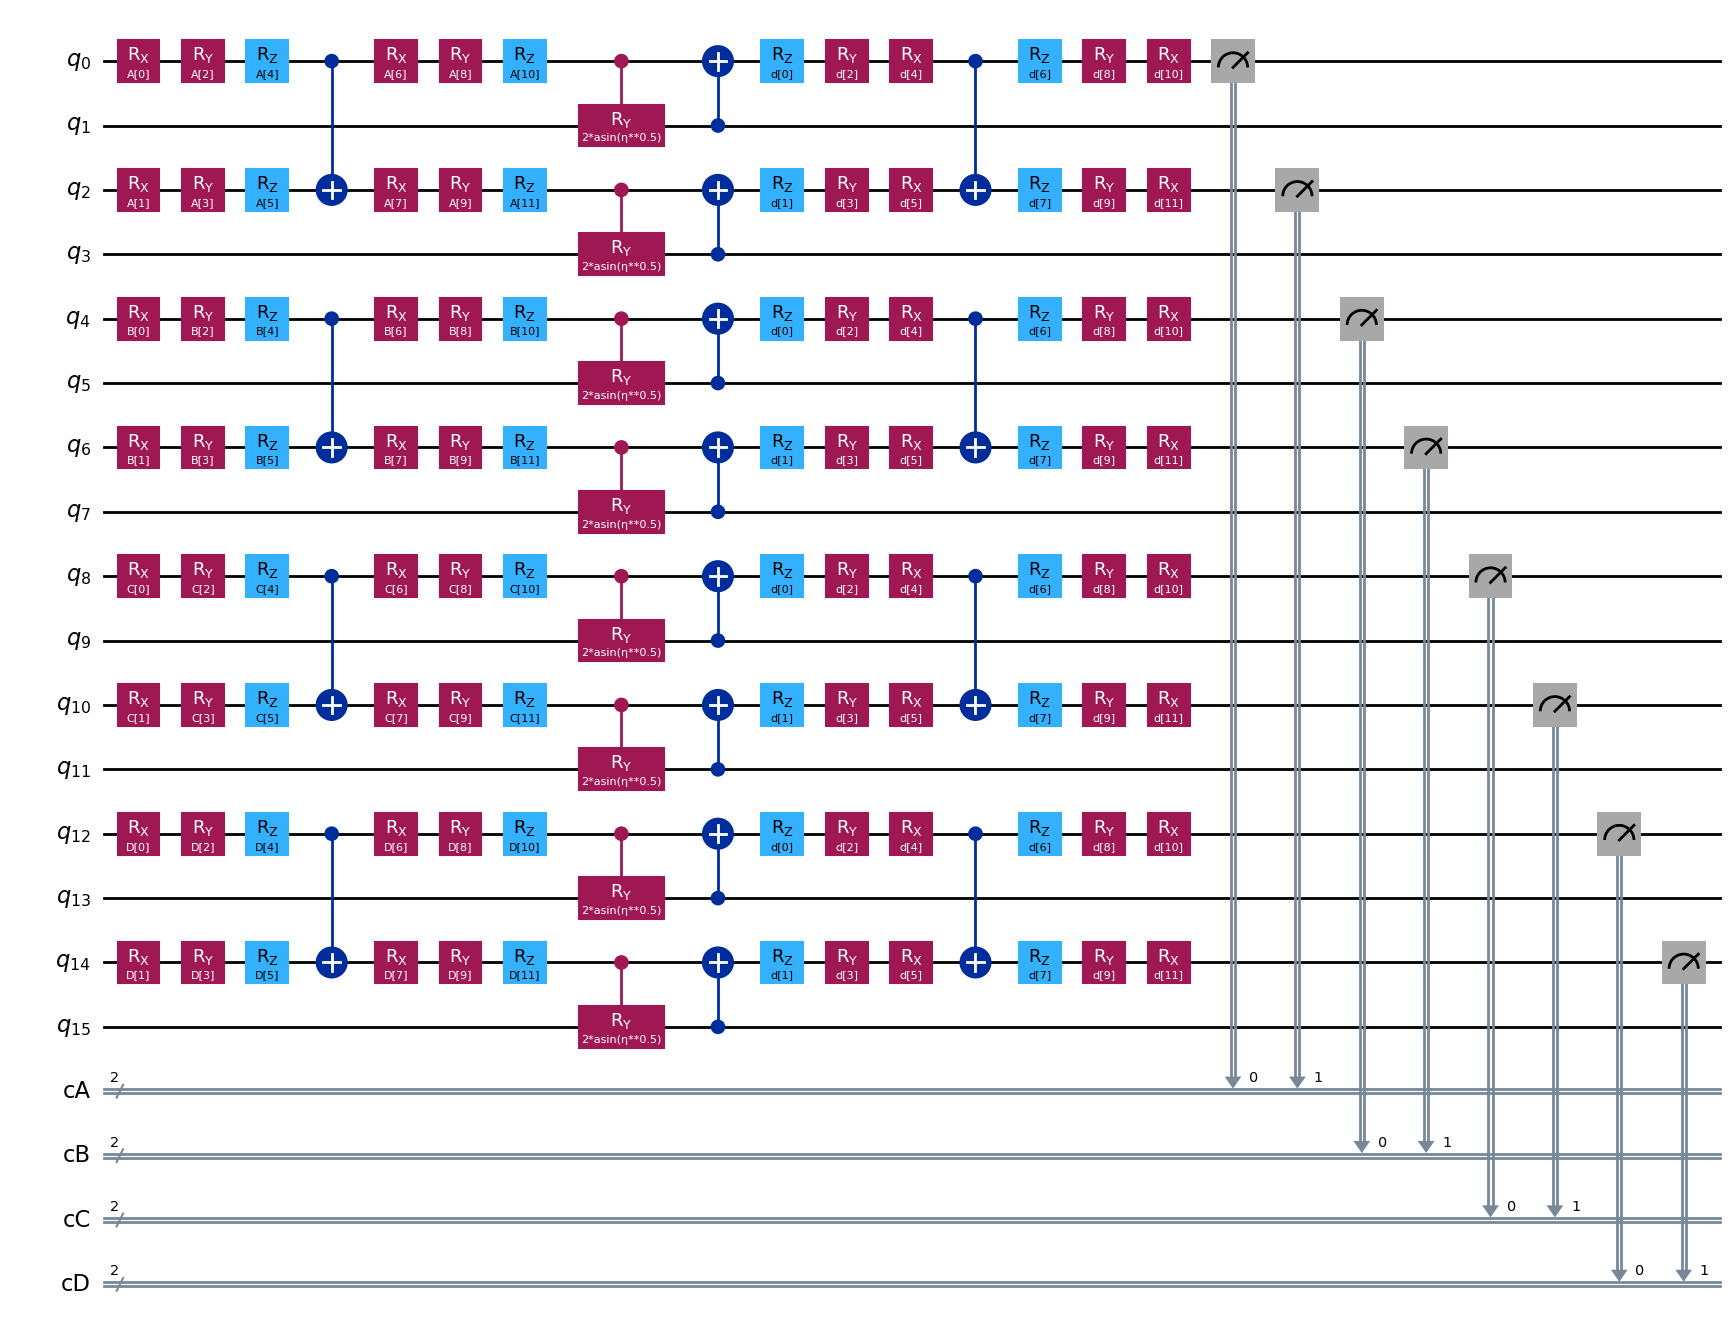

Starting the optimization procedure.
Initial trust-region radius: 1.0.
Final trust-region radius: 0.0001.
Maximum number of function evaluations: 30000.
Maximum number of iterations: 400.

cost_wrapper_scipy_mode_2([ 1.483e+00  4.003e+00 ...  2.836e+00  2.779e+00]) = 0.5835625
cost_wrapper_scipy_mode_2([ 2.483e+00  4.003e+00 ...  2.836e+00  2.779e+00]) = 0.6014124999999999
cost_wrapper_scipy_mode_2([ 1.483e+00  5.003e+00 ...  2.836e+00  2.779e+00]) = 0.59085
cost_wrapper_scipy_mode_2([ 1.483e+00  4.003e+00 ...  2.836e+00  2.779e+00]) = 0.5953875
cost_wrapper_scipy_mode_2([ 1.483e+00  4.003e+00 ...  2.836e+00  2.779e+00]) = 0.58585
cost_wrapper_scipy_mode_2([ 1.483e+00  4.003e+00 ...  2.836e+00  2.779e+00]) = 0.5667875
cost_wrapper_scipy_mode_2([ 1.483e+00  4.003e+00 ...  2.836e+00  2.779e+00]) = 0.6075125
cost_wrapper_scipy_mode_2([ 1.483e+00  4.003e+00 ...  2.836e+00  2.779e+00]) = 0.526575
cost_wrapper_scipy_mode_2([ 1.483e+00  4.003e+00 ...  2.836e+00  2.779e+00]) = 0.5885875
cost_w

In [18]:
if save : 
    salva_plot_png(qc_be_opt.draw("mpl"), base_name = "circuito_ottimizzazione", base_dir=radice,subfolder=risultati, _create=True)
display(qc_be_opt.draw("mpl"))
all_simulation = []
for n in noises:
    start_time = time.time()
    cost_history = []
    qc_set_noise = qc_be_opt.assign_parameters({noise : n})
    cost_wrapper_scipy_mode_2(x0,qc_set_noise, 10000, mode, cost_history)
    result = minimize(
        cost_wrapper_scipy_mode_2,
        x0,
        args=(qc_set_noise, 20000, mode, cost_history),
        method=met0,
        bounds=np.array(list([(-0*np.pi, 2*np.pi)]*qc_set_noise.num_parameters)),
        tol = 0.0001,
        options={
                "maxiter": 400, 
                "disp": True,
                }
    )
    # result = minimize(
    #     cost_wrapper_scipy_mode_2,
    #     result.x,
    #     args=(qc_set_noise, 400000, mode, cost_history),
    #     method=met1,
    #     bounds=np.array(list([(-0*np.pi, 2*np.pi)]*qc_set_noise.num_parameters)),
    #     tol = 0.000001,
    #     options={
    #             "maxiter": 500, 
    #             "disp": True,
    #             }
    # )
    all_simulation.append((result,cost_history,n))
    end_time = time.time()
    execution_time = end_time - start_time
    print(result)
    print(f"""print optimal parameters: {result.x}""")
    print(f"""Number of iterations: {result.nfev}""")
    print(f"""Time (s): {execution_time}""")
    print(f"""result: {result.fun}""")
    
x0_min = []
c_m = 1
for (r,_,n) in all_simulation:

    prob_min_err_single_channel_teorico_no_ent = 0.5 * (1-np.sqrt(1-n))
    prob_min_err_doble_channel_teorico_prodotto_no_ent = 1 - np.square(1-prob_min_err_single_channel_teorico_no_ent)
    d  =  r.fun - prob_min_err_doble_channel_teorico_prodotto_no_ent
    if (d < c_m and n!=0):
        x0_min = r.x
        c_m = d
if len(x0_min)==0:
    x0_min = result.x

for i in range(len(all_simulation)):
    _,cost_history,n = all_simulation[i]
    start_time = time.time()
    qc_set_noise = qc_be_opt.assign_parameters({noise : n})
    cost_wrapper_scipy_mode_2(x0_min,qc_set_noise, 10000, mode, cost_history)
    result = minimize(
        cost_wrapper_scipy_mode_2,
        x0_min,
        args=(qc_set_noise, 60000, mode, cost_history),
        method=met0,
        bounds=np.array(list([(-0*np.pi, 2*np.pi)]*qc_set_noise.num_parameters)),
        tol = 0.001,
        options={
                "maxiter": 200, 
                "disp": True,
                }
    )
    all_simulation[i] = ((result,cost_history,n))
    end_time = time.time()
    execution_time = end_time - start_time
    print(result)
    print(f"""print optimal parameters: {result.x}""")
    print(f"""Number of iterations: {result.nfev}""")
    print(f"""Time (s): {execution_time}""")
    print(f"""result: {result.fun}""")


# Risultati

## Salva dati in un file formato {"input" : x0, "results" : all_simulations}

In [19]:

with open(radice+"/data.pkl", "wb") as f:
    pickle.dump({"input":x0,"results":all_simulation}, f)

## Leggi dati da un file 

In [12]:

with open(radice+"/data.pkl", "rb") as f:
    data = pickle.load(f)
x0 = data["input"]
all_simulation = data["results"]

## grafici funzione costo

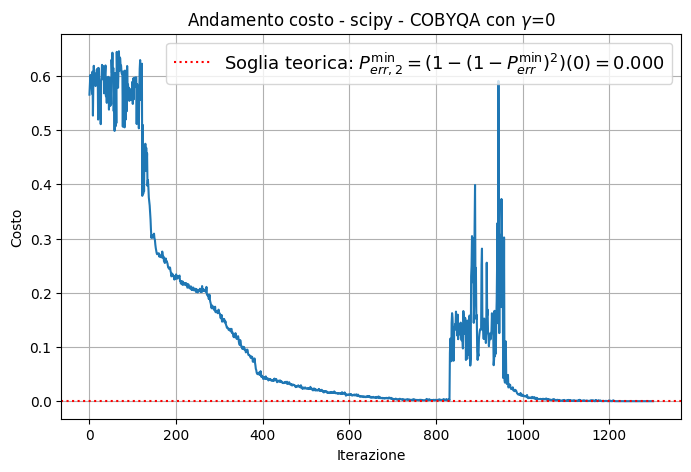

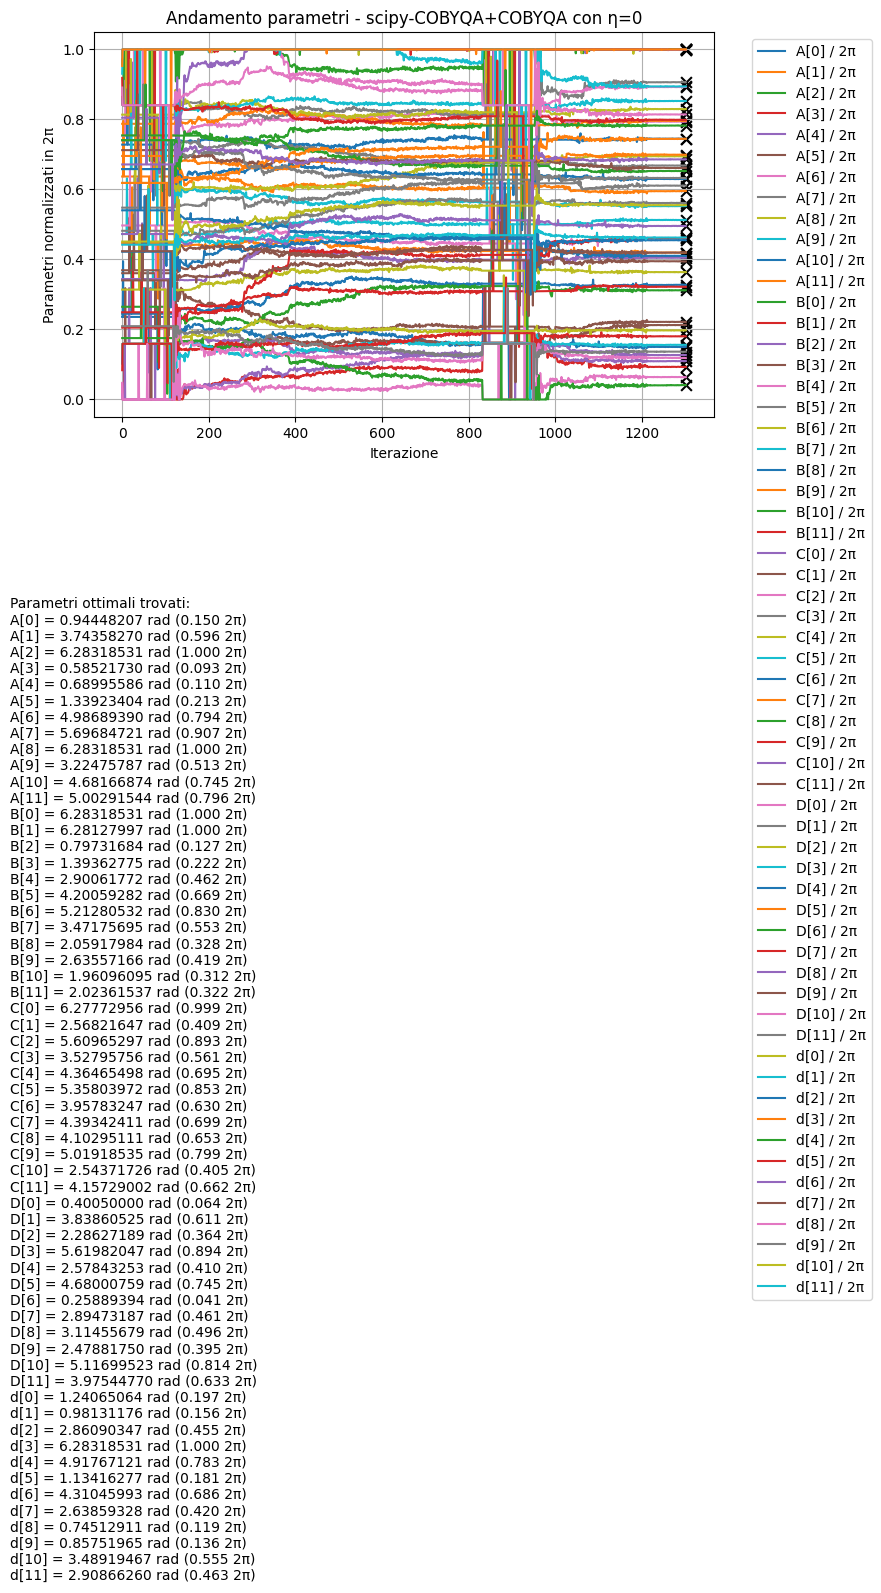

In [20]:
import matplotlib.pyplot as plt
for elem in all_simulation:
    result, cost_history, n = elem
    cost, param = ( lambda arr: (
        arr[:, 0].tolist(),           # lista dei costi
        arr[:, 1:].tolist()           # lista delle liste dei parametri
    ))(np.array(cost_history))
    
    param = np.array(param)
    # pr = [p.name + "A" for p in new_param_circuit]
    # pr = [ p.name for k in keys_sorted for p in label_params[k]] 
    # pr.extend([p.name for p in De.parameters])
    # print(qc_set_noise.parameters)
    param_temp = qc_be_opt.parameters
    param_temp.remove(noise)
    pr = [p.name for p in param_temp]

    prob_min_err_single_channel_teorico_no_ent = 0.5 * (1-np.sqrt(1-n))
    prob_min_err_doble_channel_teorico_prodotto_no_ent = 1 - np.square(1-prob_min_err_single_channel_teorico_no_ent)
    
    fig0, ax = plt.subplots(figsize=(8, 5))
    ax.plot(cost)
    ax.set_xlabel("Iterazione")
    ax.set_ylabel("Costo")
    ax.set_title(fr"Andamento costo - scipy - {met0} con $\gamma$={n}")
    ax.axhline(y=prob_min_err_doble_channel_teorico_prodotto_no_ent, color="red", linestyle=":", label = fr"Soglia teorica: $P_{{err,2}}^\min = (1-(1-P_{{err}}^\min)^2) ({n}) = {prob_min_err_doble_channel_teorico_prodotto_no_ent:.3f}$" )
    ax.legend(loc="upper right", fontsize=13)
    # ax.text(len(cost)-1,
    #         prob_min_err_doble_channel_teorico_prodotto_no_ent, 
    #         fr"$P_{{err,2}}^\min = (1-(1-P_{{err}}^\min)^2) ({n}) = {prob_min_err_doble_channel_teorico_prodotto_no_ent:.3f}$",
    #           color="red", size = 13,  va="bottom", ha="right")
    # ax.axhline(y=prob_min_err_single_channel_teorico_no_ent, color="red", linestyle=":")
    # ax.text(len(cost)-1, prob_min_err_single_channel_teorico_no_ent+ 0.01, 
    #         fr"$P_{{err}}^\min ({n}) = {prob_min_err_single_channel_teorico_no_ent:.3f}$",
    #         color="red", va="bottom", ha="right")
    ax.grid(True)
    # Aggiunge i valori finali fuori dal grafico, ad esempio in basso
    # initial_values_text = "\n".join([
    #     f"{pr[i]} = {x0[i]:.8f} rad ({x0[i]/(2*np.pi):.3f} 2π)"
    #     for i in range(len(x0))
    # ])

    # fig0.text(0.02, -0.25, f"Parametri iniziali:\n{initial_values_text}",
    #         fontsize=10, va='top', ha='left')

    #plt.tight_layout()
    #display(fig0)
    

    fig1, ax = plt.subplots(figsize=(8, 5))

    # Traccia l'andamento dei parametri
    for i in range(param.shape[1]):
        ax.plot(param[:, i] / (2*np.pi), label=f"{pr[i]} / 2π")
        ax.scatter(len(param) - 1, result.x[i] / (2*np.pi), color='black', marker='x', s=60)

    ax.set_xlabel("Iterazione")
    ax.set_ylabel("Parametri normalizzati in 2π")
    ax.set_title(f"Andamento parametri - scipy-{met0}+{met1} con η={n}")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # sposta a destra fuori dal grafico
    ax.grid(True)

    # Aggiunge i valori finali fuori dal grafico, ad esempio in basso
    final_values_text = "\n".join([
        f"{pr[i]} = {result.x[i]:.8f} rad ({result.x[i]/(2*np.pi):.3f} 2π)"
        for i in range(len(result.x))
    ])

    fig1.text(0.02, -0.25, f"Parametri ottimali trovati:\n{final_values_text}",
            fontsize=10, va='top', ha='left')
    #display(fig1)
    # plt.tight_layout()
    if save : 
        salva_plot_png(fig0, f"costo_damping_{n}", radice, risultati, _create=True, name_create=f"damping_{n}")
        salva_plot_png(fig1,f"parametri_damping_{n}",radice,risultati,_create = True,name_create=f"damping_{n}")

## grafici istogrammi degli stati e matrici densità prima di amplitude damping, il decoding amplitude damping e anche prima della misura del canale

### Preparazione delle singole componenti del canale

Esperimento con rumore 0
Istogramma esiti misurazioni del canale


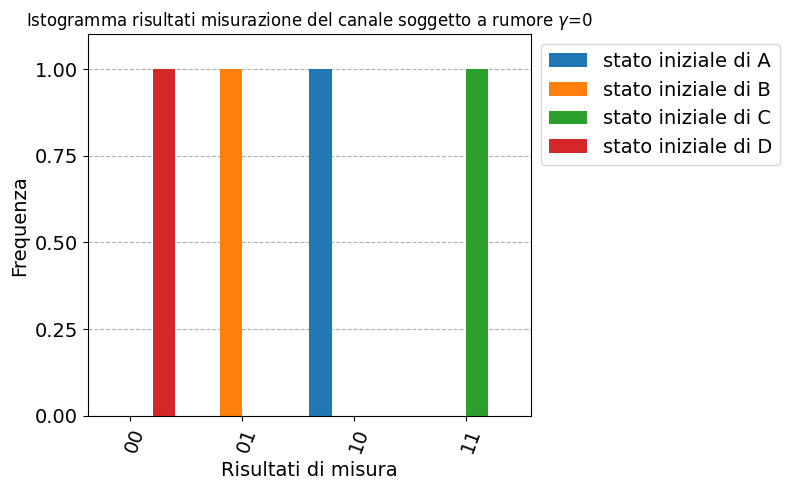

Istogramma dopo Ansatz d'ingresso, operatore di 'encoding', prima di essere soggetto a rumore


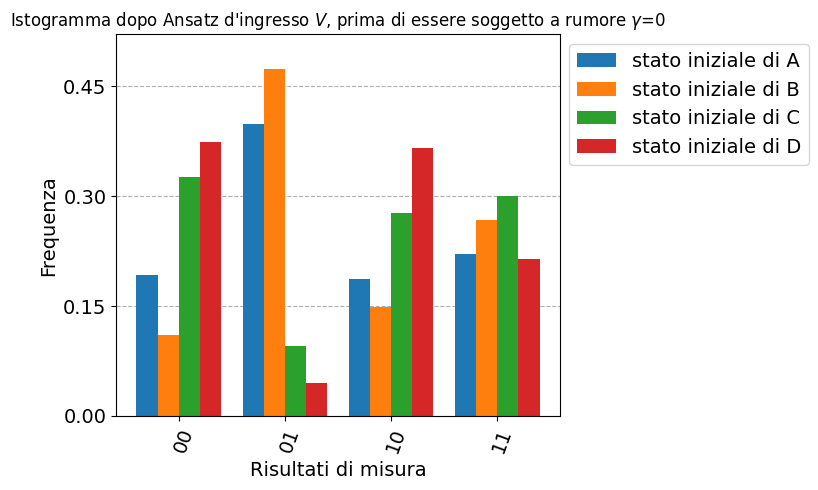

<IPython.core.display.Latex object>

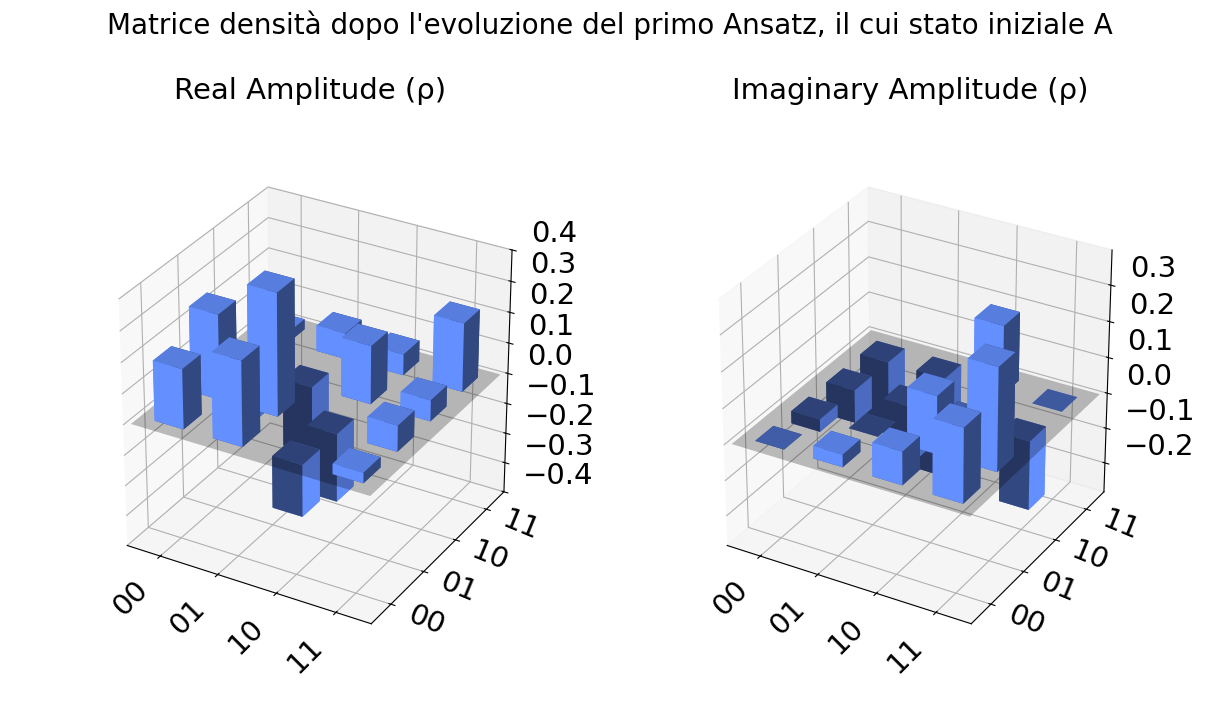

<IPython.core.display.Latex object>

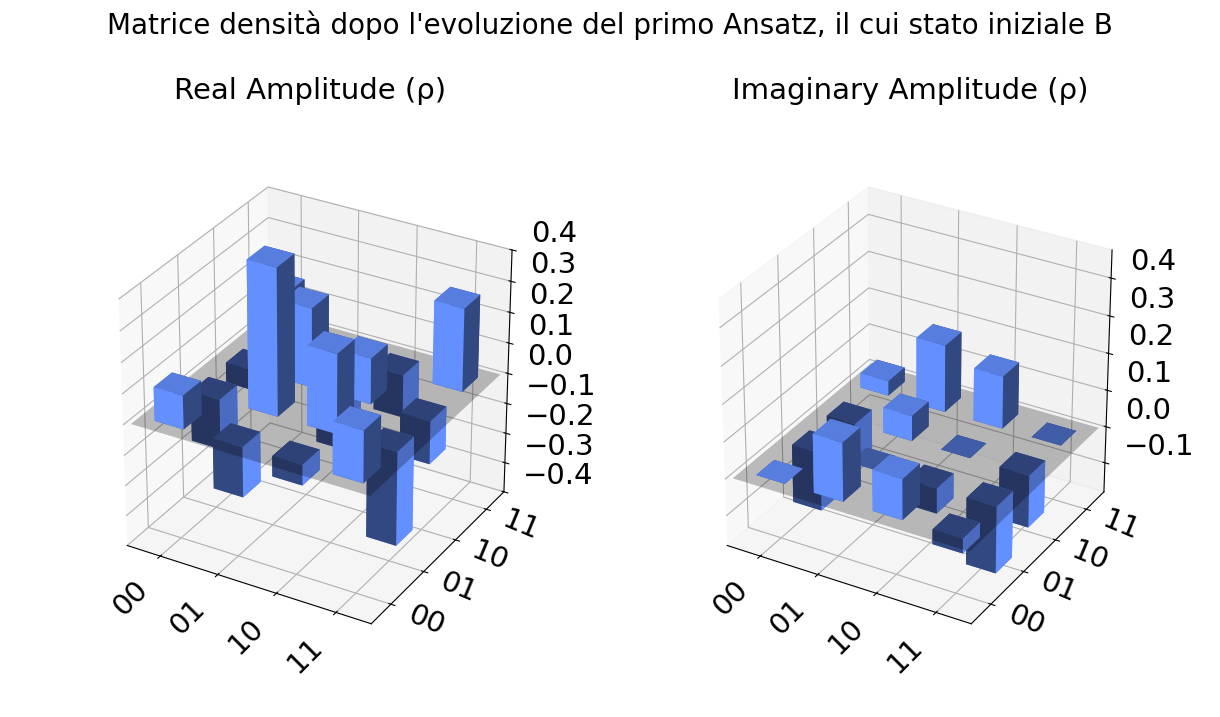

<IPython.core.display.Latex object>

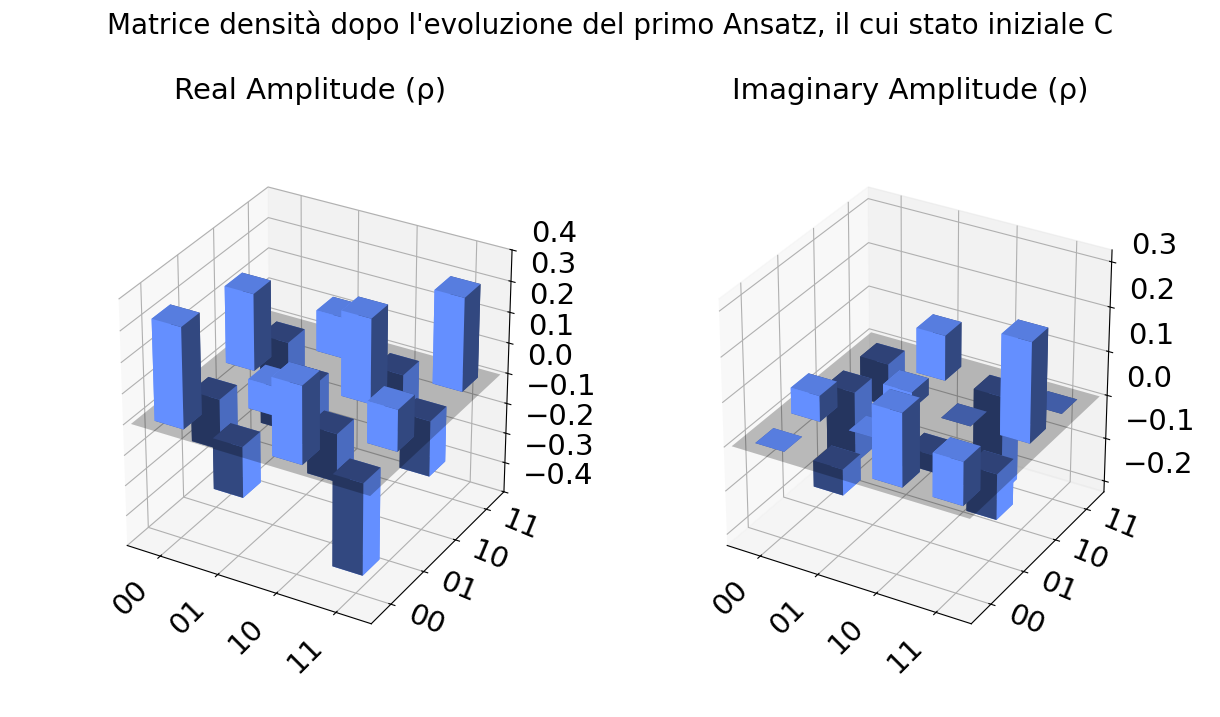

<IPython.core.display.Latex object>

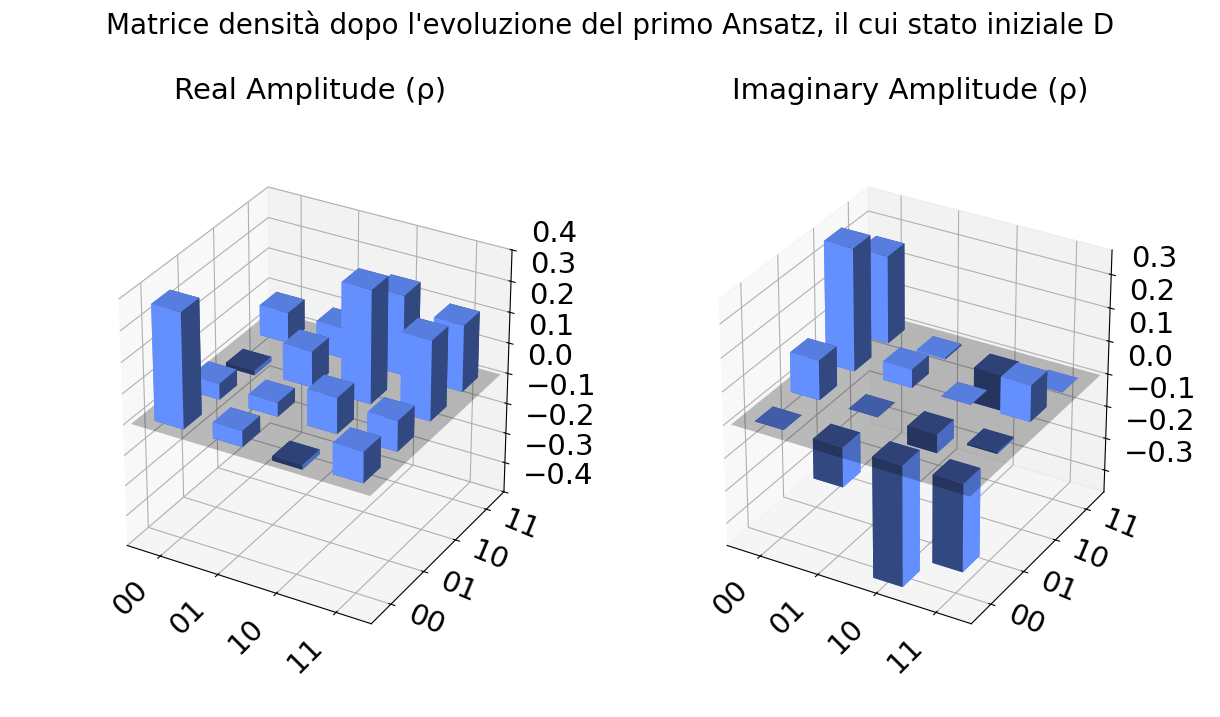

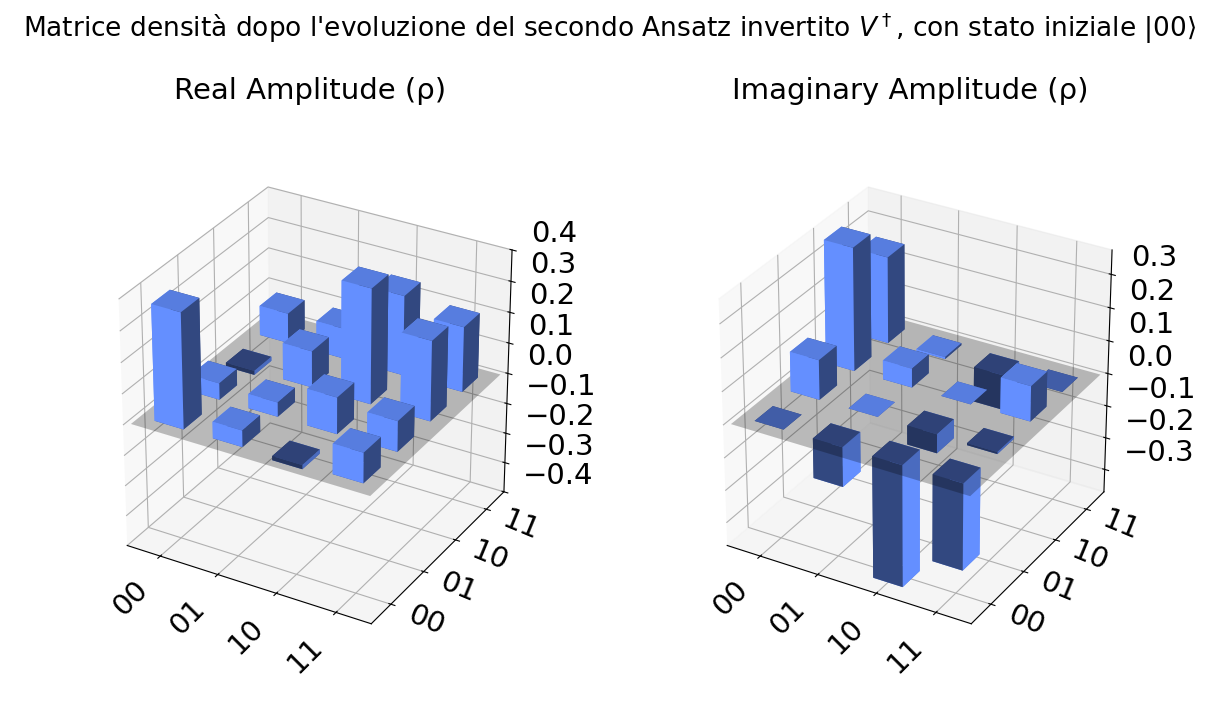

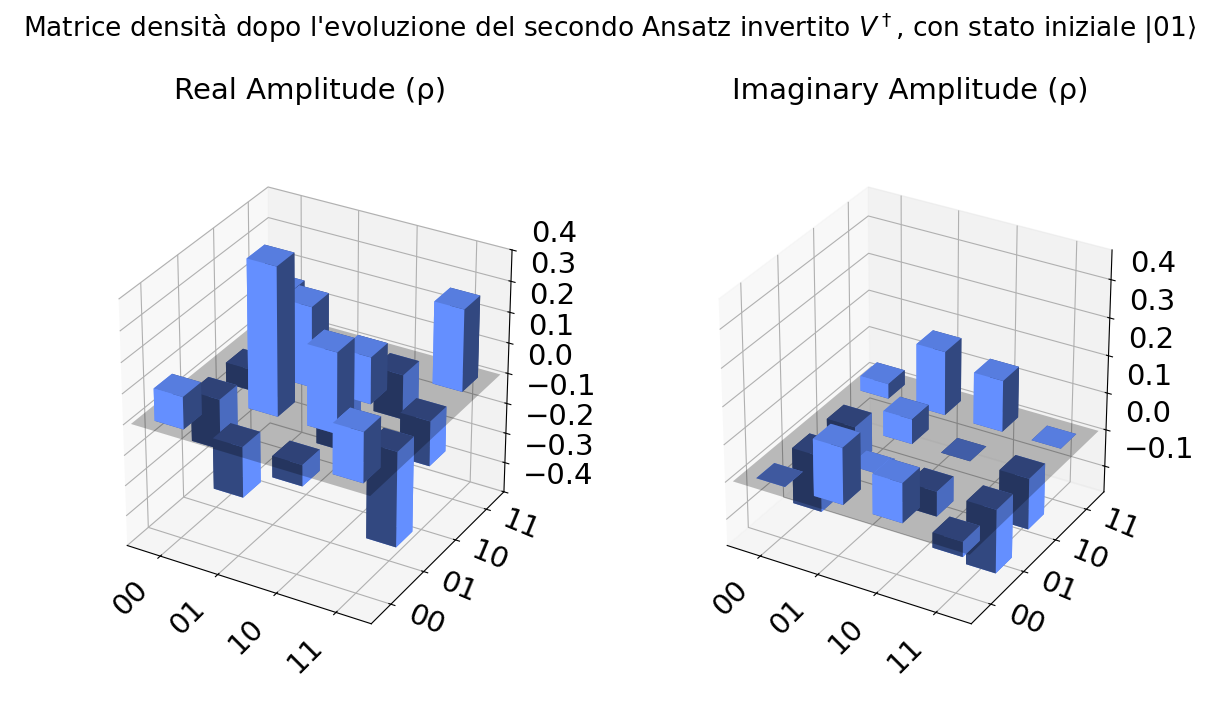

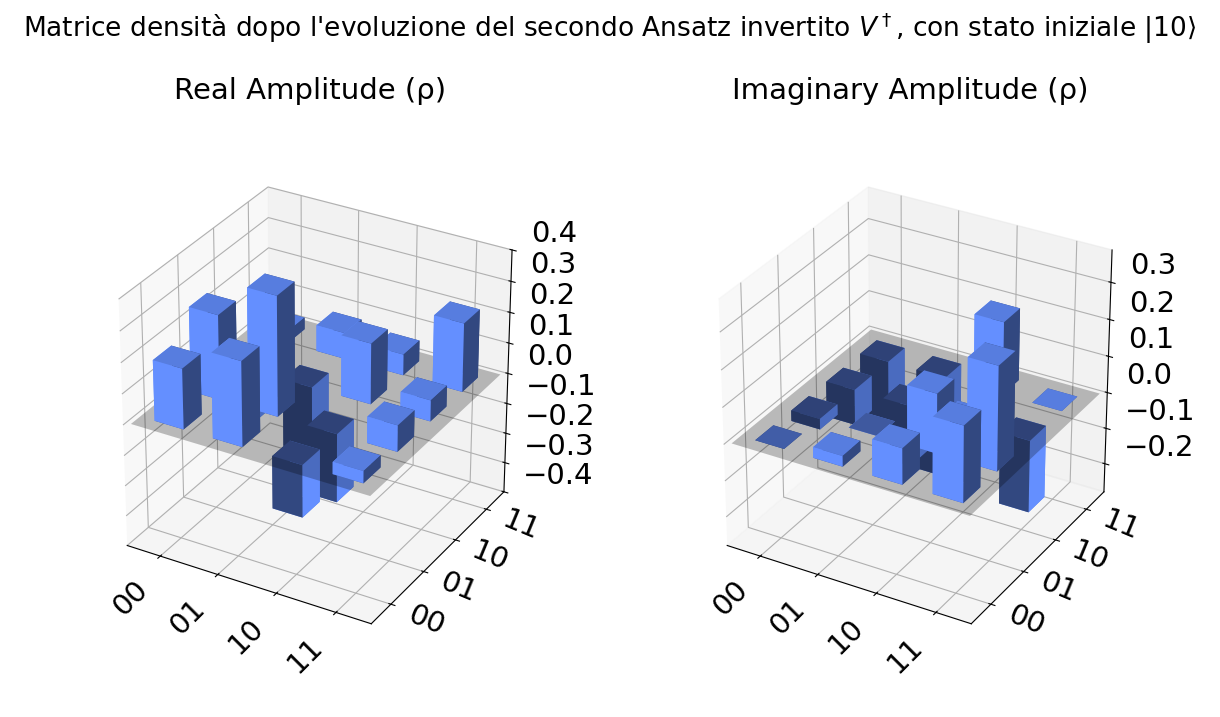

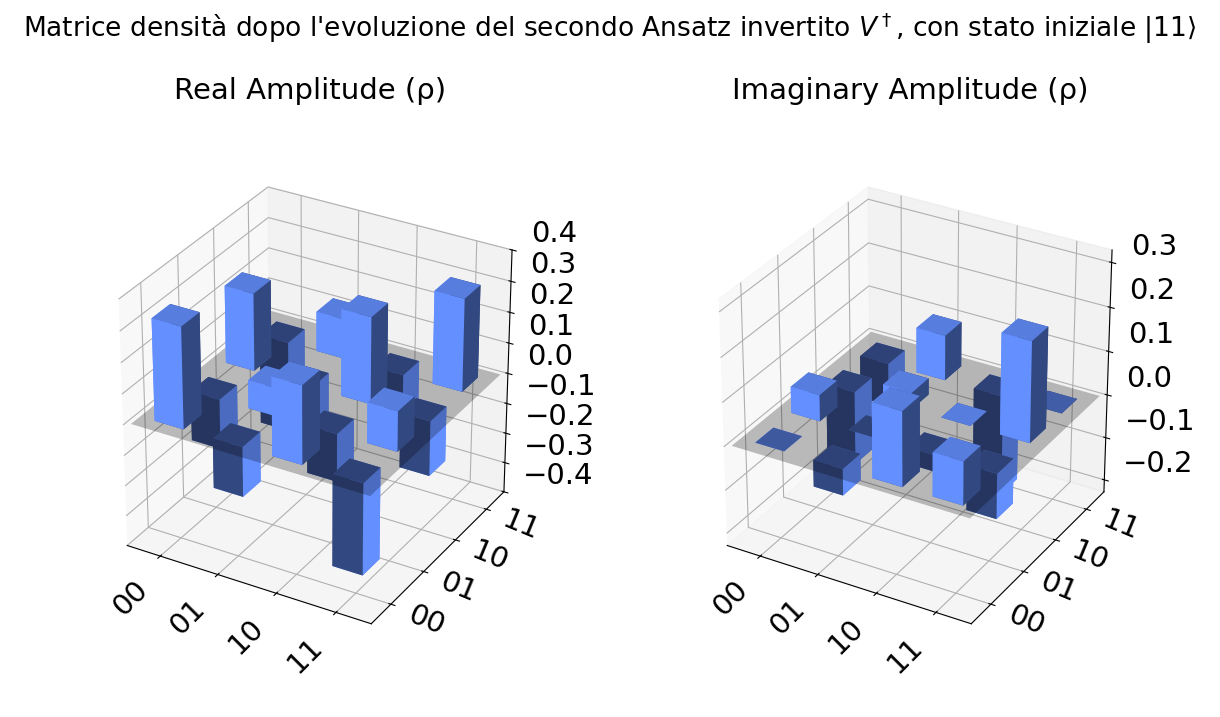

In [21]:
from qiskit.visualization import plot_histogram
En_for_data = En.copy()
De_in_for_data = De.inverse()
qc_for_data = qc_exp.copy()
counts = 100000
final_state_meas = ["00","01","10","11"]
for elem in all_simulation:
    # result, cost_history, n = all_simulation[2]
    result, cost_history, n = elem
    ex = qc_for_data.assign_parameters({noise:n})
    qc_param = ex.parameters
    # dict_channels = [{qc_param[j] : result.x[j+i*len(qc_param)] for j in range(len(qc_param))} for i in range(len(keys_sorted))]
    # dA = {param_circuit[i] : result.x[i] for i in range(len(param_circuit))}
    # dB = {param_circuit[i] : result.x[i+len(param_circuit)] for i in range(len(param_circuit))}
    not_fixed_par = []
    fixed_par = []
    for i in range(len(keys_sorted)):
        not_fixed_par.append({En.parameters[j] : result.x[j+i*(En.num_parameters)] for j in range((En.num_parameters))})
        if(i == len(keys_sorted)-1):
            fixed_par.append({De.parameters[j] : result.x[j+(i+1)*(De.num_parameters)] for j in range((De.num_parameters))})
    dict_channels = [ {**d , **u } for u in fixed_par for d in not_fixed_par ]
    #print(dict_channels)

    print(f"Esperimento con rumore {n}")
    print("Istogramma esiti misurazioni del canale")
    results = IdealSimulator().run([(ex,dict_channels[i],counts) for i in range(len(dict_channels))])
    normalize_data =[{k: v/counts for k, v in results[i].data.c.get_counts().items()} for i in range(num_channels)]
    #print(normalize_data)
    image0 = plot_histogram(data=normalize_data, figsize = (8,5),
                           legend=["stato iniziale di "+keys_sorted[i] for i in range(num_channels)],
                        #    color=["red","blue"],
                           title=fr"Istogramma risultati misurazione del canale soggetto a rumore $\gamma$={n}",
                           bar_labels=False)
    ax = image0.axes[0]  # accedi all'asse principale
    ax.set_xlabel("Risultati di misura", fontsize=14)
    ax.set_ylabel("Frequenza", fontsize=14)
    ax.tick_params(axis='both', labelsize=14)

    # Sposta la legenda
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left',fontsize=14)
    image0.tight_layout()
    display(image0)
    print("Istogramma dopo Ansatz d'ingresso, operatore di 'encoding', prima di essere soggetto a rumore")
    En_meas = QuantumCircuit(2,2).compose(En_for_data.copy(), [0,1])
    En_meas.measure(0,0)
    En_meas.measure(1,1)
    # display(En_meas.draw("mpl"))
    # print(dict_channels[0])
    # display(En_meas.assign_parameters(dict_channels[0],strict=False).draw("mpl"))
    results = IdealSimulator().run([(En_meas.assign_parameters(dict_channels[i],strict=False),[],counts) for i in range(len(dict_channels))])
    normalize_data =[{k: v/counts for k, v in results[i].data.c.get_counts().items()} for i in range(num_channels)]
    image1 = plot_histogram(data=normalize_data,
                            figsize = (8,5),
                           legend=["stato iniziale di "+keys_sorted[i] for i in range(num_channels)],
                        #    color=["red","blue"],
                           title=fr"Istogramma dopo Ansatz d'ingresso $V$, prima di essere soggetto a rumore $\gamma$={n}",
                           bar_labels=False)
    ax = image1.axes[0]  # accedi all'asse principale
    ax.set_xlabel("Risultati di misura", fontsize=14)
    ax.set_ylabel("Frequenza", fontsize=14)
    ax.tick_params(axis='both', labelsize=14)

    # Sposta la legenda
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left',fontsize=14)
    image1.tight_layout()
    display(image1)
    # De_meas = QuantumCircuit(2,2)
    # De_meas.compose(De_in_for_data.copy(), [0,1],inplace=True)
    # De_meas.measure(0,0)
    # De_meas.measure(1,1)
    # De_meases = []
    # for i in range(len(final_state_meas)):
    #     t = De_meas.copy()
    #     t.initialize(Statevector.from_label(final_state_meas[i]),[0,1])
    #     t.compose(De_meas,[0,1],inplace=True)
    #     De_meases.append(t)
    # pubs = [(De_meases[i].assign_parameters(d,strict=False),[],counts) for d in [dA,dB] for i in range(len(final_state_meas))]
    # results = IdealSimulator().run(pubs)
    # normalize_data =[{k: v/counts for k, v in r.data.c.get_counts().items()} for r in results]
    # image2 = plot_histogram(data=normalize_data,
    #                        legend=[f"stato iniziale {l} {i}" for l in ["A","B"]for i in final_state_meas],
    #                     #    color=["red","blue"],
    #                        title=f"Istogramma Ansatz d'uscita invertito nel tempo, su più stati iniziali, operatore di 'dencoding', caso rumore η={n}",
    #                        bar_labels=False)
    # display(image2)
    image_en = []
    image_de = []
    for i in range(len(keys_sorted)):
        state = DensityMatrix.from_label("00").evolve(En_for_data.assign_parameters(dict_channels[i],strict=False))
        display(state.draw(("latex")))
        fig = state.draw("city")
        fig.set_size_inches(12, 7.5)  # ⬅️ dimensioni in pollici (larghezza, altezza)
        ax = fig.axes[0]
        
        # Imposta i limiti di visualizzazione per l'asse Z
        ax.set_zlim(-0.4, 0.4)
        fig.suptitle(
                f"Matrice densità dopo l'evoluzione del primo Ansatz, il cui stato iniziale {keys_sorted[i]}",
                fontsize=20)
        display(fig)
        image_en.append((fig,i))

    for j in range(len(final_state_meas)):
        fig = DensityMatrix.from_label(final_state_meas[j]).evolve(De_in_for_data.assign_parameters(dict_channels[0],strict=False)).draw("city")
        ax = fig.axes[0]
        fig.set_size_inches(12, 7.5)  # ⬅️ dimensioni in pollici (larghezza, altezza)
        # Imposta i limiti di visualizzazione per l'asse Z
        ax.set_zlim(-0.4, 0.4)
        fig.suptitle(
            fr"Matrice densità dopo l'evoluzione del secondo Ansatz invertito $V^\dagger$, con stato iniziale $|{final_state_meas[j]}\rangle$",
            fontsize=19)
        display(fig)
        image_de.append((fig,j))
        #display(fig0)
        # print(f"matrice densita stato {keys_sorted[i]} dopo Ansatz di uscita invertito nel tempo")
        # display(DensityMatrix.from_label("11").evolve(De_in_for_data.assign_parameters(dict_channels[i],strict=False)).draw("latex"))
    # print("matrice densita stato B dopo Ansatz di ingresso")
    # display(DensityMatrix.from_label("00").evolve(En_for_data.assign_parameters(dB,strict=False)).draw("latex"))
    # print("matrice densita stato B dopo Ansatz di uscita invertito nel tempo")
    # display(DensityMatrix.from_label("00").evolve(De_in_for_data.assign_parameters(dB,strict=False)).draw("latex"))
    if save : 
        salva_plot_png(image1, f"Isto_distribuzione_encoder_{n}",radice,visualizzazione,_create = True, name_create = f"damping_{n}")
        salva_plot_png(image0, f"Isto_distribuzione_finale_{n}",radice,visualizzazione,_create = True, name_create = f"damping_{n}")
        salva_plot_png(En_for_data.draw("mpl"),"circuito_visualizzazione_encoding",radice,visualizzazione)
        salva_plot_png(De_in_for_data.draw("mpl"),"circuito_visualizzazione_decoding",radice,visualizzazione)
        salva_plot_png(qc_for_data.draw("mpl"),"circuito_completo",radice,visualizzazione)
        # salva_plot_png(image2, f"Isto_distribuzione_decoder_{n}",radice,visualizzazione,_create = True, name_create = f"damping_{n}")
        for (fig,i) in image_en:
            salva_plot_png(fig
                            , f"matrice_encode_{keys_sorted[i]}_{n}",radice,visualizzazione,_create = True, name_create = f"damping_{n}")
        for (fig,j) in image_de :
            salva_plot_png(fig, f"matrice_decode_state_{final_state_meas[j]}_damp_{n}",radice,visualizzazione,_create = True, name_create = f"damping_{n}")

                # salva_plot_png(DensityMatrix.from_label(final_state_meas).evolve(En_for_data.assign_parameters(dB,strict=False)).draw("city")
                #             , f"matrice_encode_B_{n}",radice,visualizzazione,_create = True, name_create = f"damping_{n}")
                # salva_plot_png(DensityMatrix.from_label(final_state_meas).evolve(De_in_for_data.assign_parameters(dB,strict=False)).draw("city")
                #             , f"matrice_decode_B_{n}",radice,visualizzazione,_create = True, name_create = f"damping_{n}")
